In [1]:
%pylab inline
data_dir = './data/'
fname_beans = {
    'ggood': data_dir + 'green_good.txt',
    'gspoiled': data_dir + 'green_spoil.txt',
    'gswollen': data_dir + 'green_water.txt',
    'gstale': data_dir + 'green_old.txt',
    'rgood': data_dir + 'red_good.txt',
    'rspoiled': data_dir + 'red_spoil.txt',
    'rswollen': data_dir + 'red_water.txt',
    'rstale': data_dir + 'red_old.txt'
}
labels = {
    'ggood': 0,
    'gspoiled': 1,
    'gswollen': 2,
    'gstale': 3,
    'rgood': 0,
    'rspoiled': 1,
    'rswollen': 2,
    'rstale': 3
}

Populating the interactive namespace from numpy and matplotlib


In [2]:
d_samples={}
d_labels = {}
import pickle
import numpy as np
for k, v in fname_beans.items():
    with open('./output/'+k+'.pkl','rb') as f:
        s = pickle.load(f)
    sampleK = np.stack(s)
    d_samples[k] = sampleK
    d_labels[k] = np.ones(sampleK.shape[0]) * labels[k]
    
d_samples[k].shape

(140, 520)

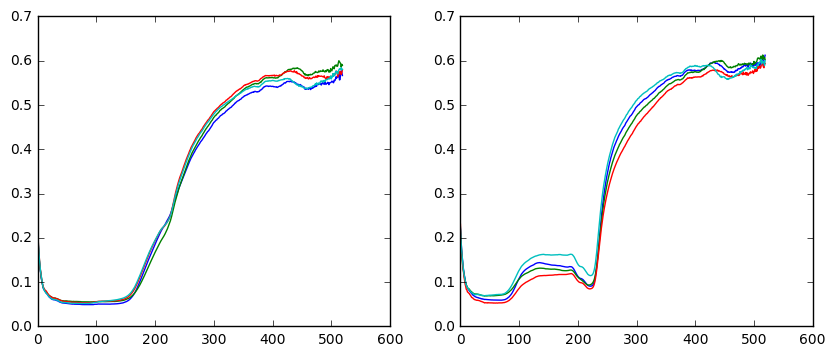

In [3]:
hold
figure(figsize=(10,4))
subplot(1,2,1)
plot(np.average(d_samples['rgood'], axis=0))
plot(np.average(d_samples['rstale'], axis=0))
plot(np.average(d_samples['rspoiled'], axis=0))
plot(np.average(d_samples['rswollen'], axis=0))
subplot(1,2,2)
plot(np.average(d_samples['ggood'], axis=0))
plot(np.average(d_samples['gstale'], axis=0))
plot(np.average(d_samples['gspoiled'], axis=0))
plot(np.average(d_samples['gswollen'], axis=0))

- 更多参考： https://scikit-learn.org/stable/auto_examples/linear_model/plot_multi_task_lasso_support.html

In [10]:
import numpy as np
import sklearn.preprocessing as skp

def split_train_test(train_percent, X, y, shuffle=True, normalize=True):
    N = y.shape[0]
    idx = list(range(N))
    if shuffle:
        np.random.shuffle(idx)
    if normalize:
        X = skp.normalize(X, axis=1)
    X = X[idx]
    y = y[idx]
    trainN = int(N * train_percent)
    return X[0:trainN], y[0:trainN], X[trainN: N], y[trainN:N]

In [11]:
from sklearn.preprocessing import OneHotEncoder
gX = np.concatenate([d_samples['ggood'], d_samples['gspoiled'], d_samples['gswollen'], d_samples['gstale']])
gY = np.concatenate([d_labels['ggood'], d_labels['gspoiled'], d_labels['gswollen'], d_labels['gstale']])

rX = np.concatenate([d_samples['rgood'], d_samples['rspoiled'], d_samples['rswollen'], d_samples['rstale']])
rY = np.concatenate([d_labels['rgood'], d_labels['rspoiled'], d_labels['rswollen'], d_labels['rstale']])

gXtr, gYtr, gXte, gYte = split_train_test(0.8, gX, gY, True)
gYtr_bin = OneHotEncoder(sparse=False).fit_transform(gYtr[:, np.newaxis])
gYte_bin = OneHotEncoder(sparse=False).fit_transform(gYte[:, np.newaxis])

rXtr, rYtr, rXte, rYte = split_train_test(0.8, rX, rY, True)
rYtr_bin = OneHotEncoder(sparse=False).fit_transform(rYtr[:, np.newaxis])
rYte_bin = OneHotEncoder(sparse=False).fit_transform(rYte[:, np.newaxis])

In [12]:
from sklearn.linear_model import MultiTaskLasso, Lasso
gamma = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05 ,0.1]
def getAccuracy(model, X, Y):
    Ypred = np.argmax(model.predict(X), axis=1)
    errCount = len(np.nonzero(Ypred - Y)[0])
    N = Ypred.shape[0]
    return 1-errCount/N

In [13]:
gBestModel = None
rBestModel = None
for alpha in gamma:
    # LBS band selection
    gLBS = Lasso(alpha=alpha, max_iter=100000).fit(gXtr, gYtr_bin)
    rLBS = Lasso(alpha=alpha, max_iter=100000).fit(rXtr, rYtr_bin)
    
    gAcc = getAccuracy(gLBS, gXte, gYte)
    gN = gXte.shape[0]
    rAcc = getAccuracy(rLBS, rXte, rYte)
    rN = rXte.shape[0]
    
    print(alpha, (gAcc* gN+ rAcc*rN)/(rN+gN))

1e-05 0.986046511627907
5e-05 0.9302325581395349
0.0001 0.8697674418604651
0.0005 0.44651162790697674
0.001 0.30697674418604654
0.005 0.30697674418604654
0.01 0.30697674418604654
0.05 0.30697674418604654
0.1 0.30697674418604654


In [14]:
for alpha in gamma:
    # LBS band selection
    MJFS = MultiTaskLasso(alpha=alpha, max_iter=100000).fit(
        np.concatenate([gXtr, rXtr]), np.concatenate([gYtr_bin, rYtr_bin]))
    
    gAcc = getAccuracy(MJFS, gXte, gYte)
    gN = gXte.shape[0]
    rAcc = getAccuracy(MJFS, rXte, rYte)
    rN = rXte.shape[0]
    
    print(alpha, (gAcc* gN+ rAcc*rN)/(rN+gN))

1e-05 0.9953488372093023
5e-05 0.9674418604651163
0.0001 0.8837209302325582
0.0005 0.4790697674418605
0.001 0.30697674418604654
0.005 0.30697674418604654
0.01 0.30697674418604654
0.05 0.30697674418604654
0.1 0.30697674418604654
